# OCC daily EDA

EDA de dataset por día

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

date_str = "20230724"

#df = spark.read.json("harvester/occ/tests/test-gdl.jsonl")
#df = spark.read.json("harvester/occ/tests/test-cdmx/sneaky*.jsonl.gz")
#df = spark.read.json("test-cdmx.jsonl") #from ETL
#df = spark.read.json("test-full-occ.jsonl") #from ETL
df = spark.read.json(f"occ-{date_str}.jsonl")
categories = spark.read.json(f"occ-{date_str}-categories.json")
subcategories = spark.read.json(f"occ-{date_str}-subcategories.json")

In [3]:
df.printSchema()

root
 |-- Job:value: string (nullable = true)
 |-- __typename: string (nullable = true)
 |-- applied: boolean (nullable = true)
 |-- autoinclusion: struct (nullable = true)
 |    |-- __typename: string (nullable = true)
 |    |-- autoinclusion: boolean (nullable = true)
 |    |-- source: string (nullable = true)
 |-- bullets: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- __ref: string (nullable = true)
 |-- category: struct (nullable = true)
 |    |-- __ref: string (nullable = true)
 |-- company: struct (nullable = true)
 |    |-- __typename: string (nullable = true)
 |    |-- confidential: boolean (nullable = true)
 |    |-- logoUrl: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- namePretty: string (nullable = true)
 |    |-- profile: struct (nullable = true)
 |    |    |-- __ref: string (nullable = true)
 |    |-- rel: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- contact: struct (nullable =

In [4]:
df.show(1, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Número de Registros

In [5]:
dfu = df.dropDuplicates(["id"])
record_count = dfu.count()
print(f"Registros totales: {df.count()}, id unicos: {record_count}")

Registros totales: 137284, id unicos: 133901


### Por tipo de redireccionamiento

- 0: No redireccionadas
- 1: ? (¿redireccionamiento pagado?)
- 2: Redir fuera del sitio (¿son agregadas?)

In [6]:
dfu.groupby("redirect.type").count().show()

+----+-----+
|type|count|
+----+-----+
|   0|75856|
|   1| 3803|
|   2|54242|
+----+-----+



### Por tipo de anuncio
Tablas para todas las vacantes y paras las únicas. 

Notar que las Premium parecen tener mas duplicadas, puede ser por el proceso de scraping cuando aparecen en varios SERP

In [7]:
df.groupby("jobType").count().show()

+--------+------+
| jobType| count|
+--------+------+
| PREMIUM|  3170|
|STANDOUT| 28321|
| CLASSIC|105793|
+--------+------+



In [8]:
dfu.groupby("jobType").count().show()

+--------+------+
| jobType| count|
+--------+------+
| PREMIUM|  2323|
|STANDOUT| 28124|
| CLASSIC|103454|
+--------+------+



### Tipo de Anuncio / redireccionamiento

CLASSIC / Redir=2 => Suponemos que son las agregadas

In [9]:
dfu.groupby("jobType").pivot("redirect.type").count().show()

+--------+-----+----+-----+
| jobType|    0|   1|    2|
+--------+-----+----+-----+
| PREMIUM| 2308|  15| null|
|STANDOUT|27659| 309|  156|
| CLASSIC|45889|3479|54086|
+--------+-----+----+-----+



#### Proporciones por JobType

In [10]:
pdf = dfu.groupby("jobType").pivot("redirect.type").count().toPandas().fillna(0).set_index('jobType')
pdf.columns = ['NoRedir', 'Redir1', 'Redir2']
pdf.div(pdf.sum(axis=1), axis=0)

,NoRedir,Redir1,Redir2
jobType,,,
PREMIUM,0.993543,0.006457,0.000000
STANDOUT,0.983466,0.010987,0.005547
CLASSIC,0.443569,0.033628,0.522802


#### Proporciones por tipo de redir

Esto demostraría que las Redir2 son agregadas no pagadas ya que practicamente todas son clásicas

In [11]:
pdf.div(pdf.sum(axis=0), axis=1)

,NoRedir,Redir1,Redir2
jobType,,,
PREMIUM,0.030426,0.003944,0.000000
STANDOUT,0.364625,0.081252,0.002876
CLASSIC,0.604949,0.914804,0.997124


#### Proporciones del total

In [12]:
pdf.div(pdf.sum().sum())

,NoRedir,Redir1,Redir2
jobType,,,
PREMIUM,0.017237,0.000112,0.000000
STANDOUT,0.206563,0.002308,0.001165
CLASSIC,0.342708,0.025982,0.403925


## Categorias

### Totales

In [50]:
cat_count = dfu.groupby("category").count().orderBy(F.col("count").desc())
split_col = F.split(cat_count["category.__ref"].cast("String"), ":")
cat_count = cat_count.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count = cat_count.join(categories.select("id", "description"), cat_count.category_id == categories.id, how="inner")
cat_count = cat_count.select(["category_id", "description", "count"]).orderBy(F.col("count").desc())

In [52]:
cat_count = cat_count.withColumn("pct", F.col("count") / record_count)
cat_count.show(cat_count.count(), truncate=False)

+-----------+------------------------------------------------+-----+---------------------+
|category_id|description                                     |count|pct                  |
+-----------+------------------------------------------------+-----+---------------------+
|19         |Ventas                                          |29154|0.21772802294232305  |
|1          |Administrativo                                  |15681|0.11710890882069588  |
|17         |Tecnologías de la Información - Sistemas        |14692|0.10972285494507136  |
|4          |Contabilidad - Finanzas                         |13449|0.10043987722272425  |
|10         |Logística - Transporte - Distribución - Almacén |11025|0.08233695043352925  |
|11         |Manufactura - Producción - Operación            |10052|0.07507038782384     |
|9          |Ingeniería                                      |7769 |0.05802047781569966  |
|21         |Atención a clientes - Call Center               |6785 |0.050671764960679905 |

### Proporciones por tipo de Redir

In [15]:
split_col = F.split(dfu["category.__ref"].cast("String"), ":")
cat_count_redir = dfu.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count_redir = cat_count_redir.groupby("category_id").pivot("redirect.type").count()
cat_count_redir = cat_count_redir.join(categories.select("id", "description"), cat_count_redir.category_id == categories.id, how="inner")
cat_count_redir = cat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
cat_count_redir.columns = ["Category", "NoRedir", "Redir1", "Redir2"]
cat_count_redir = cat_count_redir.set_index("Category")
cat_count_redir = cat_count_redir.div(cat_count_redir.sum(axis=1), axis=0)
cat_count_redir

,NoRedir,Redir1,Redir2
Category,,,
Ventas,0.550250,0.038279,0.411470
Contabilidad - Finanzas,0.651424,0.029593,0.318983
Tecnologías de la Información - Sistemas,0.541860,0.040498,0.417642
Administrativo,0.410050,0.017282,0.572668
Logística - Transporte - Distribución - Almacén,0.583039,0.011156,0.405805
Manufactura - Producción - Operación,0.540788,0.016912,0.442300
Ingeniería,0.634316,0.025872,0.339812
Recursos humanos,0.741165,0.031955,0.226880
Atención a clientes - Call Center,0.436846,0.023434,0.539720


#### Categorías en las que OCC es débil

Mayor proporción de agregadas

In [16]:
cat_count_redir.sort_values("Redir2", ascending=False)

,NoRedir,Redir1,Redir2
Category,,,
,0.000000,0.000000,1.000000
Servicios generales - Oficios - Seguridad,0.355037,0.035632,0.609331
Administrativo,0.410050,0.017282,0.572668
Atención a clientes - Call Center,0.436846,0.023434,0.539720
Turismo - Hospitalidad - Gastronomía,0.480838,0.009358,0.509804
Manufactura - Producción - Operación,0.540788,0.016912,0.442300
Tecnologías de la Información - Sistemas,0.541860,0.040498,0.417642
Ventas,0.550250,0.038279,0.411470
Logística - Transporte - Distribución - Almacén,0.583039,0.011156,0.405805


## Subcategorías

In [17]:
subcat_count = dfu.groupby("subcategory").count().orderBy(F.col("count").desc())
split_col = F.split(subcat_count["subcategory.__ref"].cast("String"), ":")
subcat_count = subcat_count.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count = subcat_count.join(subcategories.select("id", "description"), subcat_count.subcategory_id == subcategories.id, how="inner")
subcat_count.orderBy(F.col("count").desc()).show(25, truncate=False)

+--------------------+-----+--------------+---+-------------------------------------+
|subcategory         |count|subcategory_id|id |description                          |
+--------------------+-----+--------------+---+-------------------------------------+
|{JobSubcategory:29} |9121 |29            |29 |Administración                       |
|{JobSubcategory:319}|5984 |319           |319|Ventas en general                    |
|{JobSubcategory:260}|5763 |260           |260|Atención al cliente                  |
|{JobSubcategory:149}|3898 |149           |149|Almacén - Inventario                 |
|{JobSubcategory:242}|3882 |242           |242|Desarrollo de software - Programador |
|{JobSubcategory:275}|3402 |275           |275|Administración de ventas             |
|{JobSubcategory:25} |3172 |25            |25 |Crédito y cobranza                   |
|{JobSubcategory:286}|3104 |286           |286|Ventas de campo                      |
|{JobSubcategory:78} |2976 |78            |78 |Contabi

In [18]:
split_col = F.split(dfu["subcategory.__ref"].cast("String"), ":")
subcat_count_redir = dfu.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count_redir = subcat_count_redir.groupby("subcategory_id").pivot("redirect.type").count()
subcat_count_redir = subcat_count_redir.join(subcategories.select("id", "description"), subcat_count_redir.subcategory_id == subcategories.id, how="inner")
subcat_count_redir = subcat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
subcat_count_redir.columns = ["subcategory", "NoRedir", "Redir1", "Redir2"]
subcat_count_redir = subcat_count_redir.set_index("subcategory")
subcat_count_redir = subcat_count_redir.div(subcat_count_redir.sum(axis=1), axis=0)
pd.set_option('display.max_rows', None)
subcat_count_redir

,NoRedir,Redir1,Redir2
subcategory,,,
Ventas en general,0.572694,0.047293,0.380013
Contabilidad,0.788642,0.010753,0.200605
Administración de ventas,0.647266,0.039976,0.312757
Atención al cliente,0.351553,0.020822,0.627625
Administración,0.216533,0.010306,0.773161
Ventas de campo,0.620812,0.037693,0.341495
Almacén - Inventario,0.426629,0.011801,0.561570
Reclutamiento y selección de personal,0.790393,0.019408,0.190199
Desarrollo de software - Programador,0.415250,0.070067,0.514683


In [19]:
subcat_count_redir.sort_values("Redir2", ascending=False)

,NoRedir,Redir1,Redir2
subcategory,,,
,0.000000,0.000000,1.000000
Pedicurista,0.000000,0.000000,1.000000
Taquillero,0.000000,0.000000,1.000000
Plataformas,0.000000,0.000000,1.000000
Ingeniería genética,0.000000,0.000000,1.000000
Ilustración,0.000000,0.000000,1.000000
Mesero,0.068966,0.000000,0.931034
Biotecnología,0.076923,0.000000,0.923077
Música,0.100000,0.000000,0.900000


## Google For Jobs

- Primer campo: si la oferta está disponible para G4J
- Segundo campo: (¿?) si la oferta ya está indexada por G4J

In [20]:
dfu.groupby("googleForJobs").count().sort(F.col("count").desc()).show(truncate=False)

+-----------------------------+------+
|googleForJobs                |count |
+-----------------------------+------+
|{GoogleForJobs, true, true}  |132445|
|{GoogleForJobs, false, false}|1456  |
+-----------------------------+------+



## Ubicación

### Estados

#### Distribución de vacantes por estado con suma acumulada

In [23]:
dfu_loc = dfu.select("id", F.explode("location.locations").alias("loc_data"))
state_count = dfu_loc.groupby("loc_data.state.description").count().sort(F.col("count").desc())
state_count_p = state_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
state_count_p = state_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
state_count_p.show(33)

+-------------------+-----+--------------------+-------------------+
|        description|count|                perc|             cumsum|
+-------------------+-----+--------------------+-------------------+
|   Ciudad de México|37888|  0.2829553177347443| 0.2829553177347443|
|         Nuevo León|16364| 0.12220969223530817|0.40516500997005245|
|            Jalisco|11843| 0.08844594140447047|0.49361095137452293|
|   Estado de México|10403| 0.07769172747029522| 0.5713026788448181|
|                   | 7700| 0.05750517173135376| 0.6288078505761718|
|          Querétaro| 5613|0.041919029730920605| 0.6707268803070925|
|         Guanajuato| 3637| 0.02716185838791346| 0.6978887386950059|
|    Baja California| 3637| 0.02716185838791346| 0.7250505970829193|
|          Chihuahua| 3481|0.025996818545044473| 0.7510474156279637|
|           Veracruz| 3344|0.024973674580473632| 0.7760210902084373|
|             Puebla| 3324|0.024824310498054534| 0.8008454007064919|
|           Coahuila| 2841|0.02121

#### Vacantes por estado divididas por tipo Redir, con histograma para Redir2

In [45]:
state_count = dfu.withColumn("loc_data", F.explode("location.locations"))\
                .groupby("loc_data.state.description")\
                .pivot("redirect.type").count()\
                .withColumn("total", F.col("0") + F.col("1") + F.col("2"))\
                .withColumn("NoRedirPct", F.col("0") / F.col("total"))\
                .withColumn("Redir1Pct", F.col("1") / F.col("total"))\
                .withColumn("Redir2Pct", F.col("2") / F.col("total"))\
                .sort(F.col("total").desc())

+-------------------+-----+----+-----+-----+-------------------+--------------------+-------------------+
|        description|    0|   1|    2|total|         NoRedirPct|           Redir1Pct|          Redir2Pct|
+-------------------+-----+----+-----+-----+-------------------+--------------------+-------------------+
|   Ciudad de México|21327|1311|15250|37888| 0.5628959037162162|  0.0346019847972973| 0.4025021114864865|
|         Nuevo León|12323| 375| 3666|16364| 0.7530554876558299|0.022916157418724027| 0.2240283549254461|
|            Jalisco| 7087| 154| 4602|11843| 0.5984125643840243|0.013003461960651861| 0.3885839736553238|
|   Estado de México| 7830| 242| 2331|10403| 0.7526674997596847|0.023262520426799962|0.22406997981351534|
|                   |  835| 513| 6352| 7700|0.10844155844155844| 0.06662337662337663|  0.824935064935065|
|          Querétaro| 3710| 104| 1799| 5613| 0.6609656155353644|0.018528416176732586|0.32050596828790306|
|         Guanajuato| 2473|  91| 1073| 3637| 0

count    33.000000
mean      0.458819
std       0.145564
min       0.224028
25%       0.350691
50%       0.456378
75%       0.555825
max       0.824935
Name: Redir2Pct, dtype: float64


<Axes: >

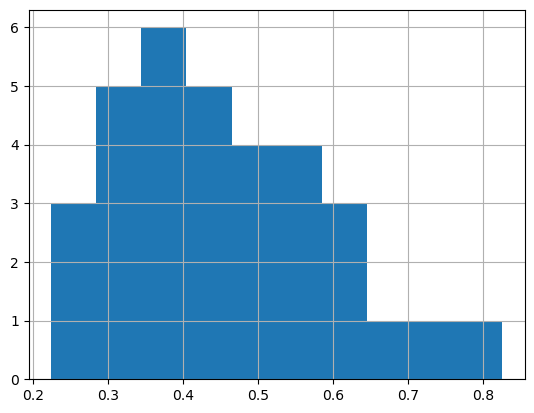

In [47]:
state_count_pd = state_count.toPandas()
print(state_count_pd["Redir2Pct"].describe())
state_count_pd["Redir2Pct"].hist()

#### Descripción (granular)

In [21]:
loc_count = dfu.groupby("location.description").count().sort(F.col("count").desc())
loc_count_p = loc_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
loc_count_p = loc_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
print(f"Número de location.description: {loc_count_p.count()}")
loc_count_p.show(30, truncate=False)

Número de location.description: 768
+---------------------------------------+-----+--------------------+-------------------+
|description                            |count|perc                |cumsum             |
+---------------------------------------+-----+--------------------+-------------------+
|Ciudad de México                       |23990|0.17916221686171127 |0.17916221686171127|
|                                       |7660 |0.05720644356651556 |0.23636866042822682|
|Monterrey, Nuevo León                  |5975 |0.04462251962270633 |0.28099118005093315|
|Jalisco                                |4796 |0.03581750696410034 |0.3168086870150335 |
|Nuevo León                             |4205 |0.031403798328615916|0.3482124853436494 |
|Guadalajara, Jalisco                   |3624 |0.027064771734341044|0.3752772570779904 |
|Miguel Hidalgo, Ciudad de México       |3147 |0.023502438368645493|0.39877969544663594|
|Estado de México                       |2790 |0.020836289497464546|0.4196

<Axes: >

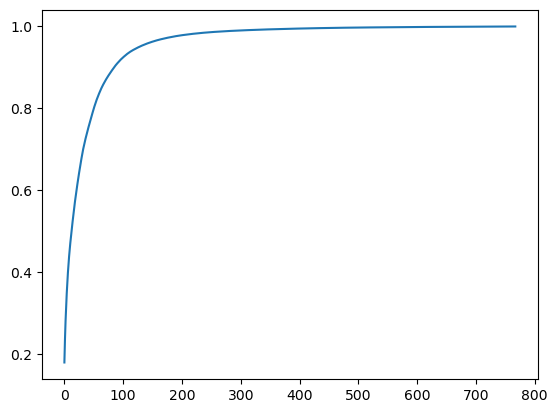

In [22]:
loc_count_p.toPandas()["cumsum"].plot()

## Compañias

Basadas en la url. 

NULL ==> Confidenciales

In [60]:
company_count = dfu.groupby("company.url").count().sort(F.col("count").desc())
print(f"Número de URLs de compañias: {company_count.count()}")
company_count.show(25, truncate=False)

Número de URLs de compañias: 14380
+---------------------------------------------------------+-----+
|url                                                      |count|
+---------------------------------------------------------+-----+
|null                                                     |16502|
|empleos/bolsa-de-trabajo-Test-and-QA-Corporation/        |8961 |
|empleos/bolsa-de-trabajo-grupo-salinas/                  |7383 |
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                |3041 |
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/            |2875 |
|empleos/bolsa-de-trabajo-Grupo-Salinas/                  |1737 |
|empleos/bolsa-de-trabajo-gepp/                           |1501 |
|empleos/bolsa-de-trabajo-truper/                         |1385 |
|empleos/bolsa-de-trabajo-Adecco/                         |944  |
|empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/         |904  |
|empleos/bolsa-de-trabajo-Banamex/                        |821  |
|empleos/bolsa-de-trabajo-Santander/     

#### Proporción de vacantes por cia y suma acumulada

In [61]:
ccp = company_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
ccp.withColumn("cumsum", F.sum(F.col("perc")).over(window)).show(30, truncate=False)

+-----------------------------------------------------------------------+-----+---------------------+-------------------+
|url                                                                    |count|perc                 |cumsum             |
+-----------------------------------------------------------------------+-----+---------------------+-------------------+
|null                                                                   |16502|0.12324030440399997  |0.12324030440399997|
|empleos/bolsa-de-trabajo-Test-and-QA-Corporation/                      |8961 |0.06692257712787805  |0.19016288153187802|
|empleos/bolsa-de-trabajo-grupo-salinas/                                |7383 |0.05513775102501101  |0.24530063255688903|
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                              |3041 |0.02271080873182426  |0.2680114412887133 |
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/                          |2875 |0.02147108684774572  |0.289482528136459  |
|empleos/bolsa-de-trabaj

### Excluyendo confidenciales

In [62]:
ccp_noconf = company_count.where("url is not null")
nconf_records = ccp_noconf.agg(F.sum("count")).collect()[0][0]
ccp_noconf = ccp_noconf.withColumn("perc", F.col("count") / nconf_records).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
ccp_noconf.withColumn("cumsum", F.sum(F.col("perc")).over(window)).show(30, truncate=False)

+-----------------------------------------------------------------------+-----+---------------------+-------------------+
|url                                                                    |count|perc                 |cumsum             |
+-----------------------------------------------------------------------+-----+---------------------+-------------------+
|empleos/bolsa-de-trabajo-Test-and-QA-Corporation/                      |8961 |0.07632944062555899  |0.07632944062555899|
|empleos/bolsa-de-trabajo-grupo-salinas/                                |7383 |0.06288809955791787  |0.13921754018347687|
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                              |3041 |0.02590311672160751  |0.16512065690508437|
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/                          |2875 |0.02448913534186833  |0.1896097922469527 |
|empleos/bolsa-de-trabajo-Grupo-Salinas/                                |1737 |0.014795696726547927 |0.20440548897350064|
|empleos/bolsa-de-trabaj

### Confidenciales

La URL null son confidenciales

In [26]:
dfu.select(["company.url", "company.name"]).where("company.confidential=TRUE").count()

16502

In [27]:
dfu.select("company.url").where("company.confidential=TRUE").distinct().count()

1

### URLs con minusculas -> agregadas

Al parecer las vacantes que tienen company.url en minusculas pero igual a otra URL son de vacantes agregadas

In [28]:
dfu.where("company.url='empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/'").count()

904

In [29]:
company_count = dfu.where("redirect.type != 2").groupby("company.url").count().sort(F.col("count").desc())
company_count.show(truncate=False)

+-----------------------------------------------------------------------+-----+
|url                                                                    |count|
+-----------------------------------------------------------------------+-----+
|null                                                                   |15929|
|empleos/bolsa-de-trabajo-Grupo-Salinas/                                |1737 |
|empleos/bolsa-de-trabajo-Adecco/                                       |944  |
|empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/                       |904  |
|empleos/bolsa-de-trabajo-Banamex/                                      |821  |
|empleos/bolsa-de-trabajo-Autofinauto/                                  |692  |
|empleos/bolsa-de-trabajo-Banorte/                                      |487  |
|empleos/bolsa-de-trabajo-Santander/                                    |465  |
|empleos/bolsa-de-trabajo-Michael-Page/                                 |358  |
|empleos/bolsa-de-trabajo-BBVA-Bancomer/

In [30]:
company_count = dfu.where("redirect.type == 2").groupby("company.url").count().sort(F.col("count").desc())
company_count.show(truncate=False)

+---------------------------------------------------------+-----+
|url                                                      |count|
+---------------------------------------------------------+-----+
|empleos/bolsa-de-trabajo-Test-and-QA-Corporation/        |8961 |
|empleos/bolsa-de-trabajo-grupo-salinas/                  |7383 |
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                |3041 |
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/            |2875 |
|empleos/bolsa-de-trabajo-gepp/                           |1501 |
|empleos/bolsa-de-trabajo-truper/                         |1385 |
|empleos/bolsa-de-trabajo-CitiGroup/                      |671  |
|empleos/bolsa-de-trabajo-bairesdev/                      |582  |
|null                                                     |573  |
|empleos/bolsa-de-trabajo-Workable-ATS/                   |413  |
|empleos/bolsa-de-trabajo-marriott-international/         |345  |
|empleos/bolsa-de-trabajo-EnsenadaHoy-com/                |320  |
|empleos/b

Hay que revisar qué nos dicen estos datos para inferir mejor 

In [31]:
dfu.where("redirect.isRedirected == TRUE").where("autoinclusion.autoinclusion == TRUE").count()

54242

In [32]:
dfu.where("redirect.isRedirected == TRUE").where("autoinclusion.autoinclusion == FALSE").count()

2155

In [33]:
dfu.where("redirect.isRedirected == FALSE").where("autoinclusion.autoinclusion == TRUE").count()

0

In [34]:
dfu.where("redirect.isRedirected == FALSE").where("autoinclusion.autoinclusion == FALSE").count()

77504

In [35]:
dfu.where("redirect.isRedirected == TRUE")\
    .where("autoinclusion.autoinclusion == TRUE")\
    .select(["scraped_url", "redirect.externalUrl"])\
    .show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|scraped_url                                                                                                                       |externalUrl                                                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|https://www.occ.com.mx/empleo/oferta/14623656-auxiliar-de-cotizacion/                                                             |https://emple

## Salarios

In [78]:
dfu.select(["salary.from", "salary.to"]).summary().show()

+-------+-----------------+------------------+
|summary|             from|                to|
+-------+-----------------+------------------+
|  count|           133901|            133901|
|   mean|6884.119334433649| 7929.617739972069|
| stddev|12419.80393249424|14107.162224073236|
|    min|                0|                 0|
|    25%|                0|                 0|
|    50%|                0|                 0|
|    75%|            11000|             12500|
|    max|           485000|            500000|
+-------+-----------------+------------------+



Casi todas las Redir2 (agregadas) no tienen salario, vs 1/3 de las pagadas:

In [114]:
dfu.withColumn("has_salary", F.col("salary.from") != 0).groupby("redirect.type").pivot("has_salary").count().show()

+----+-----+-----+
|type|false| true|
+----+-----+-----+
|   0|25724|50132|
|   1| 2388| 1415|
|   2|51325| 2917|
+----+-----+-----+



Al parecer si alguno de los dos campos de salario es mayor a 0, el otro también lo es

In [101]:
salary = dfu.select(["salary.from", "salary.to"]).where("salary.from > 0 or salary.to > 0")
salary = salary.withColumn("avg", (F.col("from") + F.col("to")) / 2)
salary.summary().show()

+-------+------------------+------------------+------------------+
|summary|              from|                to|               avg|
+-------+------------------+------------------+------------------+
|  count|             54464|             54464|             54464|
|   mean| 16924.76613910106|19495.148079465336|18209.957109283197|
| stddev|14467.078303558244|16242.078637360348|15306.219268733543|
|    min|               207|               207|             207.0|
|    25%|              9000|             10000|            9500.0|
|    50%|             13000|             15000|           14000.0|
|    75%|             20000|             23000|           21250.0|
|    max|            485000|            500000|          492500.0|
+-------+------------------+------------------+------------------+



In [107]:
#seleccionar rangos para eliminar outliers - los percentiles son ajustados a algo que permita comparar con CT
outlier_limits = salary.select(F.percentile_approx("avg", [0.009, 0.9995]))
outlier_min, outlier_max = outlier_limits.collect()[0][0]
outlier_limits.show()

+---------------------------------------------------+
|percentile_approx(avg, array(0.009, 0.9995), 10000)|
+---------------------------------------------------+
|                                 [3750.0, 145000.0]|
+---------------------------------------------------+



In [108]:
salary = salary.where(f"avg >= {outlier_min} and avg <= {outlier_max}")
salary.summary().show()

+-------+------------------+------------------+------------------+
|summary|              from|                to|               avg|
+-------+------------------+------------------+------------------+
|  count|             53947|             53947|             53947|
|   mean|16920.513874728902| 19506.38860362949|18213.451239179194|
| stddev|12901.344845962127|14759.089060954684|13779.555027000028|
|    min|              1000|              3800|            3750.0|
|    25%|              9000|             10000|            9760.0|
|    50%|             13000|             15000|           14000.0|
|    75%|             20000|             23000|           21500.0|
|    max|            140000|            150000|          145000.0|
+-------+------------------+------------------+------------------+

